In [ ]:
https://arxiv.org/pdf/2210.14360

## Imports
---

In [24]:
# data manipulation
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

# visualization
import matplotlib.pyplot as plt
import plotly.express as px

# utils
from datetime import date, timedelta
import yfinance as yf

# system
import os
import sys
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_PATH)

# personalized modules
from src.utils.dataset import get_raw_transactions

## Reading data
--- 

In [25]:
data_path = f"{ROOT_PATH}\\src\\data\\HI-Small_Trans.csv"
transactions_df = get_raw_transactions(data_path)

In [26]:
transactions_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,"3,697.34",US Dollar,"3,697.34",US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,"14,675.57",US Dollar,"14,675.57",US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,"2,806.97",US Dollar,"2,806.97",US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,"36,682.97",US Dollar,"36,682.97",US Dollar,Reinvestment,0


## Tranformations
---

In [27]:
transformed_df = transactions_df.copy()
transformed_df.columns = [col.strip().lower().replace(" ", "_") for col in transformed_df.columns]

In [28]:
# create unique customer identifier
transformed_df["sender_customer"] = transformed_df["account"].astype(str) + "_" + transformed_df["from_bank"].astype(str)
transformed_df["receiver_customer"] = transformed_df["account.1"].astype(str) + "_" + transformed_df["to_bank"].astype(str)

In [29]:
#remove transactions with destination equal to the origin
transformed_df = transformed_df[transformed_df["payment_format"] != "Reinvestment"]

In [30]:
transformed_df["timestamp"] = pd.to_datetime(transformed_df['timestamp'])

In [31]:
transformed_df.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,sender_customer,receiver_customer
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,8000F4580_3208,8000F5340_1
8,2022-09-01 00:26:00,12,8000EC280,2439,8017BF800,7.66,US Dollar,7.66,US Dollar,Credit Card,0,8000EC280_12,8017BF800_2439
9,2022-09-01 00:21:00,1,8000EDEC0,211050,80AEF5310,383.71,US Dollar,383.71,US Dollar,Credit Card,0,8000EDEC0_1,80AEF5310_211050
10,2022-09-01 00:04:00,1,8000F4510,11813,8011305D0,9.82,US Dollar,9.82,US Dollar,Credit Card,0,8000F4510_1,8011305D0_11813
12,2022-09-01 00:08:00,1,8000F4FE0,245335,812ED62E0,4.01,US Dollar,4.01,US Dollar,Credit Card,0,8000F4FE0_1,812ED62E0_245335


In [32]:
laundering_customers = transformed_df[transformed_df["is_laundering"] == 1]["sender_customer"].unique()
transformed_df["is_laundering_customer"] = transformed_df["sender_customer"].isin(laundering_customers)

## Analisys
---

In [33]:
transformed_df.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,sender_customer,receiver_customer,is_laundering_customer
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,8000F4580_3208,8000F5340_1,False
8,2022-09-01 00:26:00,12,8000EC280,2439,8017BF800,7.66,US Dollar,7.66,US Dollar,Credit Card,0,8000EC280_12,8017BF800_2439,False
9,2022-09-01 00:21:00,1,8000EDEC0,211050,80AEF5310,383.71,US Dollar,383.71,US Dollar,Credit Card,0,8000EDEC0_1,80AEF5310_211050,False
10,2022-09-01 00:04:00,1,8000F4510,11813,8011305D0,9.82,US Dollar,9.82,US Dollar,Credit Card,0,8000F4510_1,8011305D0_11813,False
12,2022-09-01 00:08:00,1,8000F4FE0,245335,812ED62E0,4.01,US Dollar,4.01,US Dollar,Credit Card,0,8000F4FE0_1,812ED62E0_245335,False


In [34]:
transformed_df.dtypes

timestamp                 datetime64[ns]
from_bank                          int64
account                           object
to_bank                            int64
account.1                         object
amount_received                  float64
receiving_currency                object
amount_paid                      float64
payment_currency                  object
payment_format                    object
is_laundering                      int64
sender_customer                   object
receiver_customer                 object
is_laundering_customer              bool
dtype: object

In [35]:
transformed_df.describe()

,timestamp,from_bank,to_bank,amount_received,amount_paid,is_laundering
count,4597289,"4,597,289.00","4,597,289.00","4,597,289.00","4,597,289.00","4,597,289.00"
mean,2022-09-05 17:23:41.056448512,"42,397.56","64,505.81","6,343,841.43","4,709,580.19",0.00
min,2022-09-01 00:00:00,1.00,1.00,0.00,0.00,0.00
25%,2022-09-02 16:12:00,116.00,"3,881.00",201.54,202.80,0.00
50%,2022-09-06 00:16:00,"6,030.00","21,387.00","1,390.32","1,394.06",0.00
75%,2022-09-08 09:23:00,"25,847.00","122,055.00","11,152.21","11,111.53",0.00
max,2022-09-18 16:18:00,"356,303.00","356,294.00","1,046,302,363,293.48","1,046,302,363,293.48",1.00
std,NaN,"78,934.04","82,207.44","1,089,771,080.46","913,757,347.26",0.03


### Fraud
---

In [36]:
is_laundering_count = transformed_df.is_laundering.value_counts().reset_index()
fig = px.pie(
    is_laundering_count,
    values='count',
    names='is_laundering',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()

is_laundering_customer_count = transformed_df.is_laundering_customer.value_counts().reset_index()
fig = px.pie(
    is_laundering_customer_count,
    values='count',
    names='is_laundering_customer',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()

### Customers
---

In [37]:
unique_customers = set(transformed_df["sender_customer"]).union(set(transformed_df["receiver_customer"]))

In [38]:
print("Number of unique customers:", len(unique_customers))

Number of unique customers: 425115


### Amount
---

In [39]:
currency2tickers = {
    "us dollar": "usdusd",
    "euro": "eurusd",
    "swiss franc": "chfusd",
    "yuan": "cnyusd",
    "shekel": "ilsusd",
    "rupee": "inrusd",
    "uk pound": "gbpusd",
    "ruble": "rubusd",
    "yen": "jpyusd",
    "bitcoin": "btc-usd",
    "canadian dollar": "cadusd",
    "australian dollar": "audusd",
    "mexican peso": "mxnusd",
    "saudi riyal": "sarusd",
    "brazil real": "brlusd"
}
tickers2currency = {v: k for k, v in currency2tickers.items()}

In [40]:
date.today().isoformat()

'2025-12-29'

In [41]:
tickers = [
    "EURUSD=X", "CHFUSD=X", "CNYUSD=X", "ILSUSD=X", "INRUSD=X",
    "GBPUSD=X", "RUBUSD=X", "JPYUSD=X", "CADUSD=X", "AUDUSD=X",
    "MXNUSD=X", "SARUSD=X", "BRLUSD=X", "BTC-USD"
]
start_date = date.today() - timedelta(days=7)
currency_conversion = yf.download(tickers=tickers, start=start_date)
currency_conversion = currency_conversion["Close"].reset_index()
currency_conversion.columns = [column.lower().replace("=x", '') for column in currency_conversion.columns]

C:\Users\ferna\AppData\Local\Temp\ipykernel_25308\3579024653.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  14 of 14 completed


In [42]:
#get first row that all columns are not null

In [43]:
currency_conversion = currency_conversion.dropna().iloc[0:1, :]
currency_conversion["usdusd"] = 1.0
currency_conversion = currency_conversion.melt(id_vars=["date"], var_name="currency", value_name="exchange_rate")
currency_conversion["currency_name"] = currency_conversion["currency"].apply(lambda x: tickers2currency.get(x, "unknown"))
currency_conversion = currency_conversion.drop(columns=["date"])

In [44]:
transformed_df["payment_currency"] = transformed_df["payment_currency"].str.lower().str.strip()
transformed_df=transformed_df.merge(currency_conversion, left_on="payment_currency", right_on="currency_name", how="left")
transformed_df["usd_amount_paid"] = transformed_df["amount_paid"] * transformed_df["exchange_rate"]

In [45]:
transformed_df.describe()

,timestamp,from_bank,to_bank,amount_received,amount_paid,is_laundering,exchange_rate,usd_amount_paid
count,4597289,"4,597,289.00","4,597,289.00","4,597,289.00","4,597,289.00","4,597,289.00","4,597,289.00","4,597,289.00"
mean,2022-09-05 17:23:41.056448512,"42,397.56","64,505.81","6,343,841.43","4,709,580.19",0.00,"2,812.33","406,688.27"
min,2022-09-01 00:00:00,1.00,1.00,0.00,0.00,0.00,0.01,0.00
25%,2022-09-02 16:12:00,116.00,"3,881.00",201.54,202.80,0.00,0.66,180.56
50%,2022-09-06 00:16:00,"6,030.00","21,387.00","1,390.32","1,394.06",0.00,1.00,927.62
75%,2022-09-08 09:23:00,"25,847.00","122,055.00","11,152.21","11,111.53",0.00,1.17,"5,052.34"
max,2022-09-18 16:18:00,"356,303.00","356,294.00","1,046,302,363,293.48","1,046,302,363,293.48",1.00,"88,490.02","27,070,146,877.16"
std,NaN,"78,934.04","82,207.44","1,089,771,080.46","913,757,347.26",0.03,"15,520.39","27,212,088.03"


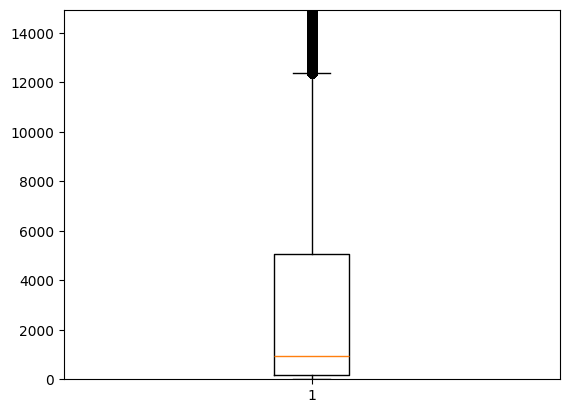

In [46]:
plt.boxplot(transformed_df["usd_amount_paid"])
plt.ylim(0, transformed_df["usd_amount_paid"].quantile(0.85))
plt.show()

### Payment format
---

In [47]:
payment_format_count = transformed_df.payment_format.value_counts().reset_index()
fig = px.pie(
    payment_format_count,
    values='count',
    names='payment_format',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.show()

In [48]:
transformed_df.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,sender_customer,receiver_customer,is_laundering_customer,currency,exchange_rate,currency_name,usd_amount_paid
0,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,us dollar,Cheque,0,8000F4580_3208,8000F5340_1,False,usdusd,1.00,us dollar,0.01
1,2022-09-01 00:26:00,12,8000EC280,2439,8017BF800,7.66,US Dollar,7.66,us dollar,Credit Card,0,8000EC280_12,8017BF800_2439,False,usdusd,1.00,us dollar,7.66
2,2022-09-01 00:21:00,1,8000EDEC0,211050,80AEF5310,383.71,US Dollar,383.71,us dollar,Credit Card,0,8000EDEC0_1,80AEF5310_211050,False,usdusd,1.00,us dollar,383.71
3,2022-09-01 00:04:00,1,8000F4510,11813,8011305D0,9.82,US Dollar,9.82,us dollar,Credit Card,0,8000F4510_1,8011305D0_11813,False,usdusd,1.00,us dollar,9.82
4,2022-09-01 00:08:00,1,8000F4FE0,245335,812ED62E0,4.01,US Dollar,4.01,us dollar,Credit Card,0,8000F4FE0_1,812ED62E0_245335,False,usdusd,1.00,us dollar,4.01


In [49]:
payment_format_laundering_df = (
    transformed_df
    .groupby("payment_format")["is_laundering"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percentage")
    .reset_index()
)

In [50]:
payment_format_laundering_df

,payment_format,is_laundering,percentage
0,ACH,0,99.25
1,ACH,1,0.75
2,Bitcoin,0,99.96
3,Bitcoin,1,0.04
4,Cash,0,99.98
5,Cash,1,0.02
6,Cheque,0,99.98
7,Cheque,1,0.02
8,Credit Card,0,99.98
9,Credit Card,1,0.02


### Date and frequency
---

In [51]:
transformed_df["hour"] = transformed_df["timestamp"].dt.hour
transformed_df["week_day"] = transformed_df["timestamp"].dt.day_name()
transformed_df["week_day_number"] = transformed_df["timestamp"].dt.day_of_week
transformed_df["month"] = transformed_df["timestamp"].dt.month

In [52]:
print(f"Min date: {transformed_df["timestamp"].min()}")
print(f"Max date: {transformed_df["timestamp"].max()}")

Min date: 2022-09-01 00:00:00
Max date: 2022-09-18 16:18:00


In [ ]:
timestamp_no_fraud_df = (
    transformed_df
    .groupby(["week_day", "week_day_number", "hour"], as_index=False)
    .sender_customer.count()
    .rename(columns={"sender_customer": "count"})
)
timestamp_no_fraud_df = timestamp_no_fraud_df.sort_values(by=["week_day_number", "hour"])

timestamp_customer_fraud_df = (
    transformed_df[transformed_df["is_laundering_customer"] == 1]
    .groupby(["week_day", "week_day_number", "hour"], as_index=False)
    .sender_customer.count()
    .rename(columns={"sender_customer": "count"})
)
timestamp_customer_fraud_df = timestamp_customer_fraud_df.sort_values(by=["week_day_number", "hour"])

timestamp_transactions_fraud_df = (
    transformed_df[transformed_df["is_laundering"] == 1]
    .groupby(["week_day", "week_day_number", "hour"], as_index=False)
    .sender_customer.count()
    .rename(columns={"sender_customer": "count"})
)
timestamp_transactions_fraud_df = timestamp_transactions_fraud_df.sort_values(by=["week_day_number", "hour"])

In [ ]:
px.density_heatmap(timestamp_no_fraud_df, x='week_day', y='hour', z='count', color_continuous_scale='Viridis', title="No Fraud Transactions").show()
px.density_heatmap(timestamp_customer_fraud_df, x='week_day', y='hour', z='count', color_continuous_scale='Viridis', title="Customer Fraud Transactions").show()
px.density_heatmap(timestamp_transactions_fraud_df, x='week_day', y='hour', z='count', color_continuous_scale='Viridis', title="Fraud Transactions").show()

In [ ]:
transactions_frequency = (
    transformed_df.groupby(by=["sender_customer", "month"], as_index=False)
    .usd_amount_paid.count()
    .groupby(by=["sender_customer"], as_index=False)
    .usd_amount_paid.mean()
    .rename(columns={"usd_amount_paid": "count"})
)

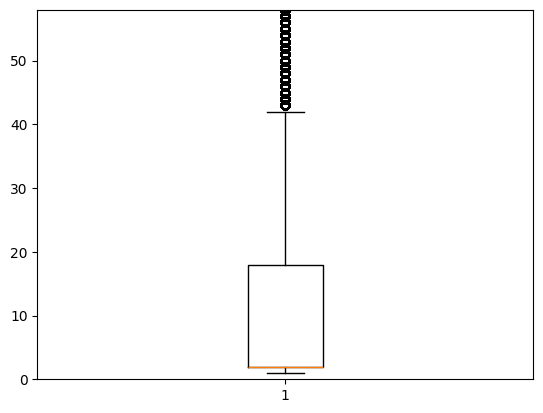

In [ ]:
plt.boxplot(transactions_frequency["count"])
plt.ylim(0, transactions_frequency["count"].quantile(0.95))
plt.show()